In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imagenet10data/val/n01440764/ILSVRC2012_val_00041939.JPEG
/kaggle/input/imagenet10data/val/n01494475/ILSVRC2012_val_00021325.JPEG
/kaggle/input/imagenet10data/val/n01498041/ILSVRC2012_val_00006402.JPEG
/kaggle/input/imagenet10data/val/n01484850/ILSVRC2012_val_00044052.JPEG
/kaggle/input/imagenet10data/val/n01514668/ILSVRC2012_val_00003606.JPEG
/kaggle/input/imagenet10data/val/n01491361/ILSVRC2012_val_00030926.JPEG
/kaggle/input/imagenet10data/val/n01443537/ILSVRC2012_val_00002241 copy 2.JPEG
/kaggle/input/imagenet10data/val/n01443537/ILSVRC2012_val_00002241 copy.JPEG
/kaggle/input/imagenet10data/val/n01443537/ILSVRC2012_val_00002241.JPEG
/kaggle/input/imagenet10data/val/n01518878/ILSVRC2012_val_00017839.JPEG
/kaggle/input/imagenet10data/val/n01514859/ILSVRC2012_val_00021430.JPEG
/kaggle/input/imagenet10data/val/n01496331/ILSVRC2012_val_00042751.JPEG
/kaggle/input/imagenet10data/train/n01440764/n01440764_2923.JPEG
/kaggle/input/imagenet10data/train/n01494475/n01494475_1618

In [2]:
# Create a mapping from WordNet IDs to class names
id_to_class = {
    "n01440764": "tench",
    "n01443537": "goldfish",
    "n01484850": "great_white_shark",
    "n01491361": "tiger_shark",
    "n01494475": "hammerhead",
    "n01496331": "electric_ray",
    "n01498041": "stingray",
    "n01514668": "cock",
    "n01514859": "hen",
    "n01518878": "ostrich"
}

In [3]:
#Importing Libraries
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
from time import time
from tqdm import tqdm

In [4]:
# Setting up the device for GPU usage
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
# Define transform
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
# Create the dataset
train_dataset = datasets.ImageFolder('/kaggle/input/imagenet10data/train/', transform=transform)
val_dataset = datasets.ImageFolder('/kaggle/input/imagenet10data/val/', transform=transform)

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [7]:
# Moving the model to GPU
model = models.resnet18(pretrained=True)
model = model.to(device) 

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s] 


Label index: 0
WordNet ID: n01440764
Class name: tench


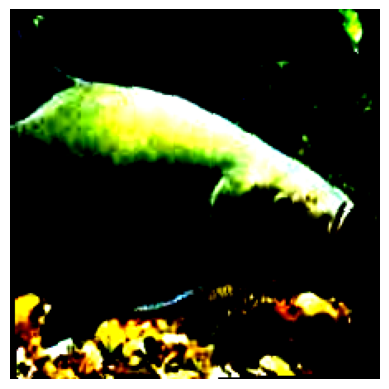

In [8]:
import matplotlib.pyplot as plt

# Show an image
def show_image(image):
    plt.imshow(image.permute(1, 2, 0))
    plt.axis('off')
    plt.show()

# Invert the class_to_idx mapping
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

# Get an image and label
image, label_idx = train_dataset[0]

# Map the label index to the WordNet ID
wordnet_id = idx_to_class[label_idx]

# Map the WordNet ID to the class name
class_name = id_to_class[wordnet_id]

# Print the label and show the image
print("Label index:", label_idx)
print("WordNet ID:", wordnet_id)
print("Class name:", class_name)
show_image(image)

In [9]:
# Define the imshow function
def imshow(img, title):
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img = torch.clamp(img, 0, 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(title)
    plt.show()

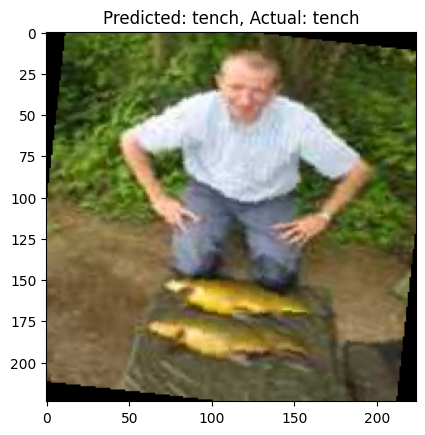

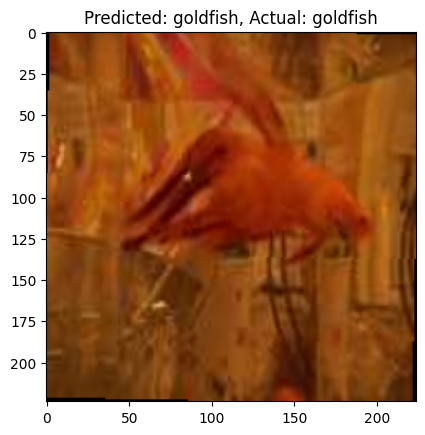

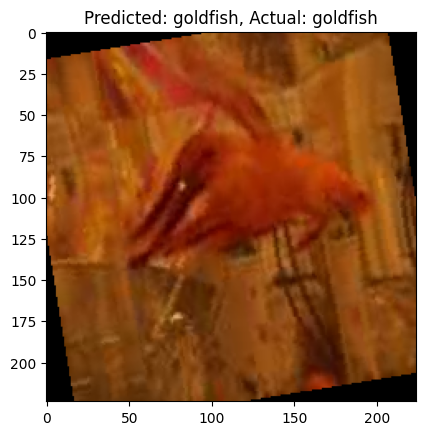

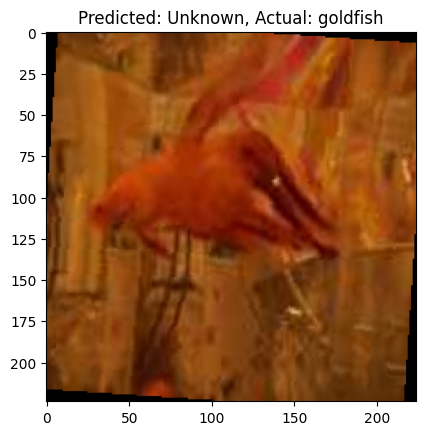

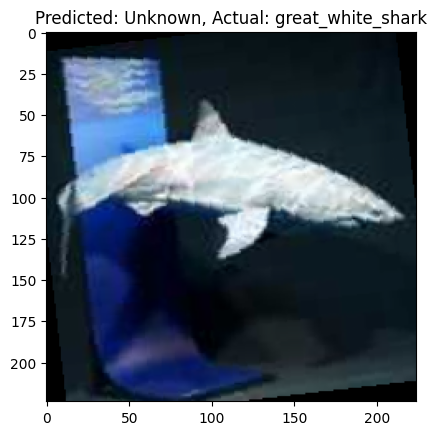

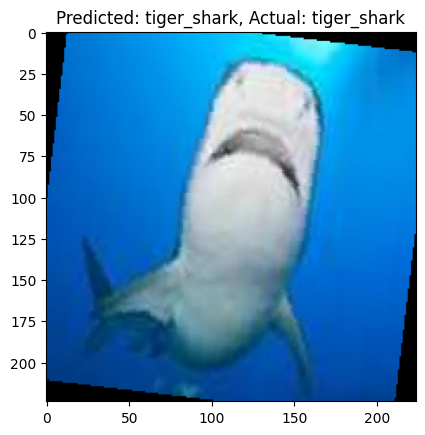

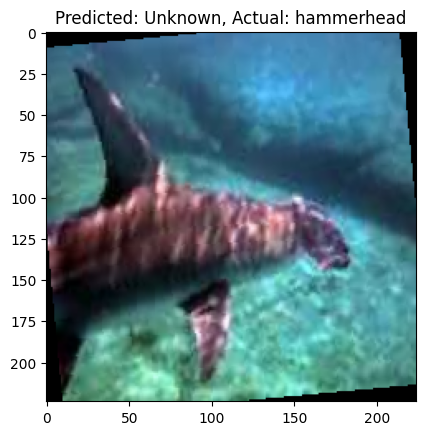

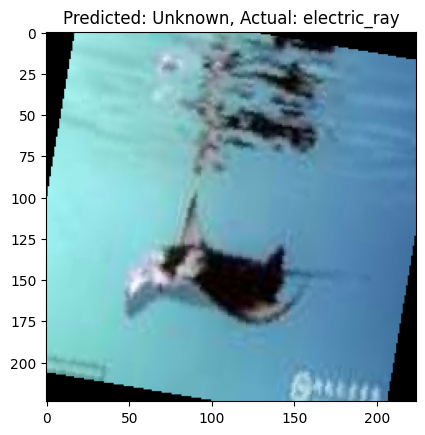

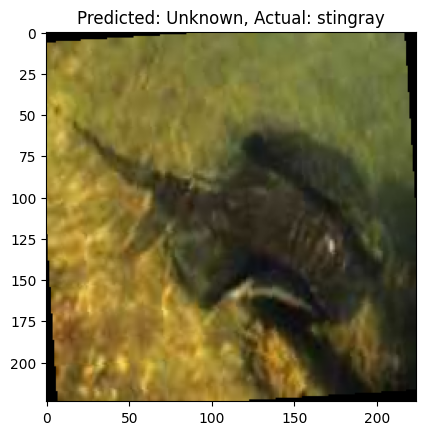

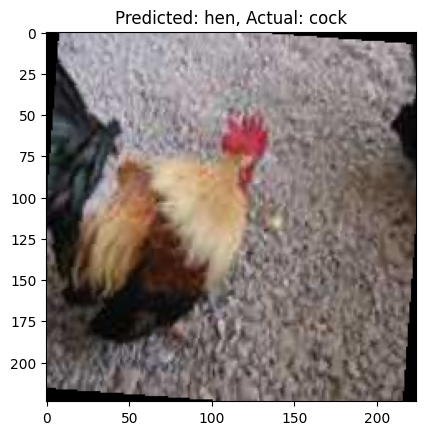

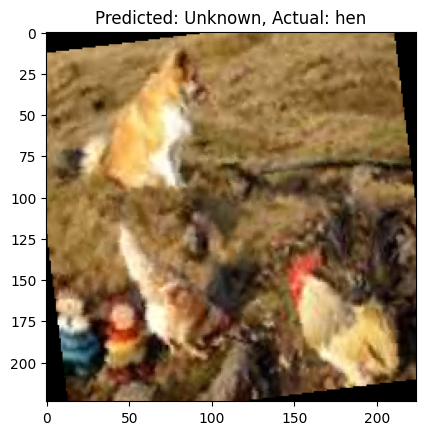

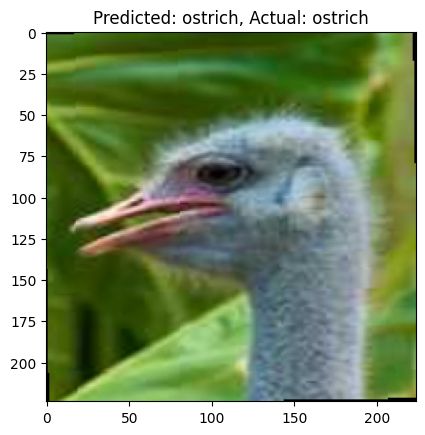

Validation Accuracy: 41.67%


In [10]:
def evaluate(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # Display sample predictions
            for i in range(len(images)):
                pred_class = idx_to_class.get(predicted[i].item(), "Unknown")
                actual_class = idx_to_class.get(labels[i].item(), "Unknown")
                pred_class_name = id_to_class.get(pred_class, "Unknown")
                actual_class_name = id_to_class.get(actual_class, "Unknown")
                imshow(images[i].cpu(), f'Predicted: {pred_class_name}, Actual: {actual_class_name}')

    accuracy = 100 * correct / total
    return accuracy

# Evaluate on validation set
val_accuracy = evaluate(model, val_loader, device)
print('Validation Accuracy: {:.2f}%'.format(val_accuracy))

# **Testing Another Model by Replacing Layers: **

In [5]:
# Imports
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt

In [6]:
# Transform
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [7]:
# Create Datasets and DataLoaders
train_dataset = datasets.ImageFolder('/kaggle/input/imagenet10data/train/', transform=transform)
val_dataset = datasets.ImageFolder('/kaggle/input/imagenet10data/val/', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [8]:
model2 = models.resnet18(pretrained=True)
num_ftrs = model2.fc.in_features
model2.fc = nn.Linear(num_ftrs, 10)
model2 = model2.to(device)

In [9]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

In [10]:
# Training Operation
def train(model, data_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(data_loader.dataset)
    epoch_acc = running_corrects.double() / len(data_loader.dataset)
    return epoch_loss, epoch_acc

In [11]:
# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train(model2, train_loader, criterion, optimizer, device)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

# Evaluate the model
val_loss, val_acc = evaluate(model2, val_loader, device)
print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Epoch 1/10, Train Loss: 2.2839, Train Acc: 0.2000
Epoch 2/10, Train Loss: 0.3755, Train Acc: 1.0000
Epoch 3/10, Train Loss: 0.0282, Train Acc: 1.0000
Epoch 4/10, Train Loss: 0.0121, Train Acc: 1.0000
Epoch 5/10, Train Loss: 0.0096, Train Acc: 1.0000
Epoch 6/10, Train Loss: 0.0045, Train Acc: 1.0000
Epoch 7/10, Train Loss: 0.0020, Train Acc: 1.0000
Epoch 8/10, Train Loss: 0.0035, Train Acc: 1.0000
Epoch 9/10, Train Loss: 0.0012, Train Acc: 1.0000
Epoch 10/10, Train Loss: 0.0009, Train Acc: 1.0000


TypeError: cannot unpack non-iterable float object

# **Testing another Method via Freezing**

In [4]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets and dataloaders
train_dataset = datasets.ImageFolder('/kaggle/input/imagenet10data/train/', transform=transform)
val_dataset = datasets.ImageFolder('/kaggle/input/imagenet10data/val/', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Load pre-trained model
model3 = models.resnet18(pretrained=True)

# Freeze all the layers
for param in model3.parameters():
    param.requires_grad = False

# Replace the final layer
num_ftrs = model3.fc.in_features
model3.fc = nn.Linear(num_ftrs, len(train_dataset.classes))

# Move the model to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model3 = model3.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.fc.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    return model

# Train the model
model3 = train_model(model3, train_loader, criterion, optimizer, num_epochs=10)

# Evaluation function
def evaluate(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Evaluate on validation set
val_accuracy = evaluate(model3, val_loader, device)
print('Validation Accuracy: {:.2f}%'.format(val_accuracy))


Epoch 1/10, Loss: 2.9849
Epoch 2/10, Loss: 2.4749
Epoch 3/10, Loss: 2.2442
Epoch 4/10, Loss: 2.1380
Epoch 5/10, Loss: 1.9718
Epoch 6/10, Loss: 2.1096
Epoch 7/10, Loss: 1.8594
Epoch 8/10, Loss: 1.8274
Epoch 9/10, Loss: 1.8095
Epoch 10/10, Loss: 1.8177
Validation Accuracy: 25.00%


# **PGD Attacks: **

I will now use PGD attacks onto the original model with 50% accuracy

In [11]:
# Importing TorchAttacks
!pip install torchattacks
import torchattacks

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 1.5 MB/s eta 0:00:00 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 4.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.6
    Uninstalling idna-3.6:
      Successfully uninstalled idna-3.6
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-cv 0.9.0 requires keras-core, which is not installed.
keras-nlp 0.12.1 requires keras-core, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not 

In [12]:
import torchattacks

In [14]:
# Initialize the PGD attack
pgd = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=40)

# Evaluate the model under attack
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Generate adversarial examples
        adv_inputs = pgd(inputs, labels)

        # Get predictions
        outputs = model(adv_inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn